In [1]:
import random
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.executing_eagerly()
from tqdm import tqdm
from collections import deque
import Shockwave_model as HS_module
import math
import keras.backend as K
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, Lambda, concatenate, BatchNormalization, GaussianNoise
from keras.regularizers import l2
from keras.initializers import RandomUniform

Using TensorFlow backend.


In [2]:
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class OrnsteinUhlenbeckProcess(object):
    """ Ornstein-Uhlenbeck Noise (original code by @slowbull)
    """
    def __init__(self, theta=0.15, mu=0, sigma=1, x0=0, dt=1e-2, n_steps_annealing=100, size=1):
        self.theta = theta
        self.sigma = sigma
        self.n_steps_annealing = n_steps_annealing
        self.sigma_step = - self.sigma / float(self.n_steps_annealing)
        self.x0 = x0
        self.mu = mu
        self.dt = dt
        self.size = size

    def generate(self, step):
        sigma = max(0, self.sigma_step * step + self.sigma)
        x = self.x0 + self.theta * (self.mu - self.x0) * self.dt + sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x0 = x
        return x

In [4]:
def tfSummary(tag, val):
    """ Scalar Value Tensorflow Summary
    """
    return tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=val)])

In [5]:
def conv_block(inp, d=3, pool_size=(2, 2), k=3):
    """ Returns a 2D Conv block, with a convolutional layer, max-pooling
    """
    conv = conv_layer(d, k)(inp)
    return MaxPooling2D(pool_size=pool_size)(conv)

In [6]:
def gather_stats(agent, env):
    """ Compute average rewards over 10 episodes
    """
    score = []
    for k in range(10):
        old_state = env.reset()
        cumul_r, done = 0, False
        while not done:
            a = agent.policy_action(old_state)
            old_state, r, done, _ = env.step(a)
            cumul_r += r
        score.append(cumul_r)
    return np.mean(np.array(score)), np.std(np.array(score))

In [7]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [8]:
class MemoryBuffer(object):
    """ Memory Buffer Helper class for Experience Replay
    using a double-ended queue or a Sum Tree (for PER)
    """
    def __init__(self, buffer_size, with_per = False):
        """ Initialization
        """
        if(with_per):
            # Prioritized Experience Replay
            self.alpha = 0.5
            self.epsilon = 0.01
            self.buffer = SumTree(buffer_size)
        else:
            # Standard Buffer
            self.buffer = deque()
        self.count = 0
        self.with_per = with_per
        self.buffer_size = buffer_size

    def memorize(self, state, action, reward, done, new_state, error=None):
        """ Save an experience to memory, optionally with its TD-Error
        """

        experience = (state, action, reward, done, new_state)
        if(self.with_per):
            priority = self.priority(error[0])
            self.buffer.add(priority, experience)
            self.count += 1
        else:
            # Check if buffer is already full
            if self.count < self.buffer_size:
                self.buffer.append(experience)
                self.count += 1
            else:
                self.buffer.popleft()
                self.buffer.append(experience)

    def priority(self, error):
        """ Compute an experience priority, as per Schaul et al.
        """
        return (error + self.epsilon) ** self.alpha

    def size(self):
        """ Current Buffer Occupation
        """
        return self.count

    def sample_batch(self, batch_size):
        """ Sample a batch, optionally with (PER)
        """
        batch = []

        # Sample using prorities
        if(self.with_per):
            T = self.buffer.total() // batch_size
            for i in range(batch_size):
                a, b = T * i, T * (i + 1)
                s = random.uniform(a, b)
                idx, error, data = self.buffer.get(s)
                batch.append((*data, idx))
            idx = np.array([i[5] for i in batch])
        # Sample randomly from Buffer
        elif self.count < batch_size:
            idx = None
            batch = random.sample(self.buffer, self.count)
        else:
            idx = None
            batch = random.sample(self.buffer, batch_size)

        # Return a batch of experience
        s_batch = np.array([i[0] for i in batch])
        a_batch = np.array([i[1] for i in batch])
        r_batch = np.array([i[2] for i in batch])
        d_batch = np.array([i[3] for i in batch])
        new_s_batch = np.array([i[4] for i in batch])
        return s_batch, a_batch, r_batch, d_batch, new_s_batch, idx

    def update(self, idx, new_error):
        """ Update priority for idx (PER)
        """
        self.buffer.update(idx, self.priority(new_error))

    def clear(self):
        """ Clear buffer / Sum Tree
        """
        if(self.with_per): self.buffer = SumTree(buffer_size)
        else: self.buffer = deque()
        self.count = 0

In [9]:
class Actor:
    """ Actor Network for the DDPG Algorithm
    """

    def __init__(self, inp_dim, out_dim, act_range, lr, tau):
        self.env_dim = inp_dim
        self.act_dim = out_dim
        self.act_range = act_range
        self.tau = tau
        self.lr = lr
        self.model = self.network()
        self.target_model = self.network()
        self.adam_optimizer = self.optimizer()

    def network(self):
        """ Actor Network for Policy function Approximation, using a tanh
        activation for continuous control. We add parameter noise to encourage
        exploration, and balance it with Layer Normalization.
        """
        inp = Input((self.env_dim,)) ######################################
        
        x = Dense(64, activation='relu')(inp)
        x = GaussianNoise(1.0)(x)
        #
        #x = Flatten()(x) #########################################
        x = Dense(128, activation='relu')(x)
        x = GaussianNoise(1.0)(x)
        #
        #x = Flatten()(x) ###########################################
        x = Dense(64, activation='relu')(x)
        x = GaussianNoise(1.0)(x)
        
        """
        inp = Input((self.env_dim,)) ###################################

        x = Dense(64, activation='relu')(inp)
        x = GaussianNoise(1.0)(x)

        #x = Flatten()(x) ##############################################
        x = Dense(32, activation='relu')(x)
        x = GaussianNoise(1.0)(x)
        """
        
        out = Dense(self.act_dim, activation='tanh', kernel_initializer=RandomUniform())(x)
        out = Lambda(lambda i: i * self.act_range)(out)
        #
        return Model(inp, out)

    def predict(self, state):
        """ Action prediction
        """
        return self.model.predict(np.expand_dims(state, axis=0))

    def target_predict(self, inp):
        """ Action prediction (target network)
        """
        return self.target_model.predict(inp)

    def transfer_weights(self):
        """ Transfer model weights to target model with a factor of Tau
        """
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):##Target_Weight
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)

    def train(self, states, actions, grads):
        """ Actor Training
        """
        self.adam_optimizer([states, grads])

    def optimizer(self):
        """ Actor Optimizer
        """
        action_gdts = K.placeholder(shape=(None, self.act_dim))
        params_grad = tf.gradients(self.model.output, self.model.trainable_weights, -action_gdts)
        grads = zip(params_grad, self.model.trainable_weights)
        #return K.function([self.model.input, action_gdts], [tf.optimizers.Adam(self.lr).apply_gradients(grads)])
        return K.function(inputs=[self.model.input, action_gdts], outputs=[K.constant(1)],updates=[tf.optimizers.Adam(self.lr).apply_gradients(grads)])
    def save(self, path):
        self.model.save_weights(path + '_actor.h5')

    def load_weights(self, path):
        self.model.load_weights(path)

In [10]:
class Critic:
    """ Critic for the DDPG Algorithm, Q-Value function approximator
    """

    def __init__(self, inp_dim, out_dim, lr, tau):
        # Dimensions and Hyperparams
        self.env_dim = inp_dim
        self.act_dim = out_dim
        self.tau, self.lr = tau, lr
        # Build models and target models
        self.model = self.network()
        self.target_model = self.network()
        self.model.compile(Adam(self.lr), 'mse')
        self.target_model.compile(Adam(self.lr), 'mse')
        # Function to compute Q-value gradients (Actor Optimization)
        self.action_grads = K.function([self.model.input[0], self.model.input[1]], K.gradients(self.model.output, [self.model.input[1]]))

    def network(self):
        """ Assemble Critic network to predict q-values
        """
        state = Input((self.env_dim,)) ############################
        action = Input((self.act_dim,))
        x = Dense(256, activation='relu')(state)
        #x = concatenate([Flatten()(x), action])
        x = concatenate([x, action]) #############################
        x = Dense(128, activation='relu')(x)
        out = Dense(1, activation='linear', kernel_initializer=RandomUniform())(x)
        return Model([state, action], out)
    
        """
        state = Input((self.env_dim,)) ###################################
        action = Input((self.act_dim,))
        x = Dense(64, activation='relu')(state)
        #x = concatenate([Flatten()(x), action])
        x = concatenate([x, action]) ###################################
        x = Dense(32, activation='relu')(x)
        out = Dense(1, activation='linear', kernel_initializer=RandomUniform())(x)
        return Model([state, action], out)
        """
        
    def gradients(self, states, actions):
        """ Compute Q-value gradients w.r.t. states and policy-actions
        """
        return self.action_grads([states, actions])

    def target_predict(self, inp):
        """ Predict Q-Values using the target network
        """
        return self.target_model.predict(inp)

    def train_on_batch(self, states, actions, critic_target):
        """ Train the critic network on batch of sampled experience
        """
        return self.model.train_on_batch([states, actions], critic_target)

    def transfer_weights(self):
        """ Transfer model weights to target model with a factor of Tau
        """
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)

    def save(self, path):
        self.model.save_weights(path + '_critic.h5')

    def load_weights(self, path):
        self.model.load_weights(path)

In [11]:
DELAY_Test = []
REWARD_Test = []

In [12]:
###################
####교차로 DDPG####
###################
class Intersection_DDPG:
    """ Deep Deterministic Policy Gradient (DDPG) Helper Class
    """

    def __init__(self, act_dim, env_dim, act_range, buffer_size = 20000, gamma = 0.99, lr = 0.00005, tau = 0.001):
        """ Initialization
        """
        # Environment and A2C parameters
        self.act_dim = act_dim
        self.act_range = act_range
        #self.env_dim = (k,) + env_dim
        self.env_dim = env_dim
        self.gamma = gamma
        self.lr = lr
        # Create actor and critic networks
        self.actor = Actor(self.env_dim, act_dim, act_range, 0.1 * lr, tau)
        self.critic = Critic(self.env_dim, act_dim, lr, tau)
        self.buffer = MemoryBuffer(buffer_size)
        #최적 신호
        self.best_signal = np.zeros(8)

    def policy_action(self, s):
        """ Use the actor to predict value
        """
        return self.actor.predict(s)[0]

    def bellman(self, rewards, q_values, dones):
        """ Use the Bellman Equation to compute the critic target
        """
        critic_target = np.asarray(q_values)
        for i in range(q_values.shape[0]):
            if dones[i]:
                critic_target[i] = rewards[i]
            else:
                critic_target[i] = rewards[i] + self.gamma * q_values[i]
        return critic_target

    def memorize(self, state, action, reward, done, new_state):
        """ Store experience in memory buffer
        """
        self.buffer.memorize(state, action, reward, done, new_state)

    def sample_batch(self, batch_size):
        return self.buffer.sample_batch(batch_size)

    def update_models(self, states, actions, critic_target):
        """ Update actor and critic networks from sampled experience
        """
        # Train critic
        self.critic.train_on_batch(states, actions, critic_target)
        # Q-Value Gradients under Current Policy
        actions = self.actor.model.predict(states)
        grads = self.critic.gradients(states, actions)
        # Train actor
        self.actor.train(states, actions, np.array(grads).reshape((-1, self.act_dim)))
        # Transfer weights to target networks at rate Tau
        self.actor.transfer_weights()
        self.critic.transfer_weights()
        
    ##여기가 학습과정!!
    def train(self, EPI, MAX_STEP, ini_S, ini_T, jct_FFS, jct_Sat, jct_W, jct_lane, jct_Link_len, jct_LT_bay,
              jct_LT_bay_len, jct_Sig_type, jct_FIFO, jct_cycle, jct_yellow, jct_offset, jct_Min_phase):

        path_actor  = "ddpg_21-0919_weight1_LR_5e-05_actor.h5"
        path_critic = "ddpg_21-0919_weight1_LR_5e-05_critic.h5"      
        self.load_weights(path_actor, path_critic)
        
        results = []

        # First, gather experience
        tqdm_e = tqdm(range(EPI), desc='Score', leave=True, unit=" episodes")
        
        epi = 0
        best_sig = np.zeros(len(ini_S))
        #신호 업데이트 여부
        update_signal = True
        #맨 처음 실행 여부
        initial_flag = True
        
        old_signal = np.zeros(len(ini_S))
        new_signal = np.zeros(len(ini_S))
        for i in range(len(ini_S)):
            old_signal[i] = ini_S[i]
            
        best_epi, best_step, ini_delay = 0, 0, 0

        for e in tqdm_e:
            # Reset episode
            step, cumul_reward, done = 0, 0, False
            actions, states, rewards = [], [], []
            noise = OrnsteinUhlenbeckProcess(size=self.act_dim)

            while not done:
                if initial_flag == True:
                    #기존 state 및 delay
                    old_state, old_delay, old_entropy = Env_Jct1(jct_FFS, jct_Sat, jct_W, jct_lane, jct_Link_len, jct_LT_bay, jct_LT_bay_len, Jct_width,
                                               jct_Sig_type, jct_FIFO, ini_T, jct_cycle, old_signal, jct_yellow, jct_offset) ######## 소문자 수정
                    ini_delay = old_delay
                    initial_flag = False

                # Actor picks an action (following the deterministic policy)
                a = self.policy_action(old_state)
                # Clip continuous values to be valid w.r.t. environment
                a = np.clip(a+noise.generate(step), -self.act_range, self.act_range)

                ## Retrieve new state, reward, and whether the state is terminal
                #action에 따른 새로운 신호 산출
                new_signal = Set_Action1(old_signal, a, jct_Min_phase)
                #기존 state 및 delay
                new_state, new_delay, new_entropy = Env_Jct1(jct_FFS, jct_Sat, jct_W, jct_lane, jct_Link_len, jct_LT_bay, jct_LT_bay_len, Jct_width,
                                               jct_Sig_type, jct_FIFO, ini_T, jct_cycle, new_signal, jct_yellow, jct_offset) ######## 소문자 수정
                #reward 산출
                r = Get_Reward1(old_delay, new_delay, old_entropy, new_entropy)
                DELAY_Test.append(new_delay)
                REWARD_Test.append(r)
                
                #done 산출
                step += 1
                if step >= MAX_STEP:
                    done = True

                # Add outputs to memory buffer
                self.memorize(old_state, a, r, done, new_state)
                # Sample experience from buffer
                states, actions, rewards, dones, new_states, _ = self.sample_batch(Batch_Size)
                # Predict target q-values using target networks
                q_values = self.critic.target_predict([new_states, self.actor.target_predict(new_states)])
                # Compute critic target
                critic_target = self.bellman(rewards, q_values, dones)
                # Train both networks on sampled batch, update target networks
                self.update_models(states, actions, critic_target)

                # Update current state
                if r > 0:
                    for i in range(len(old_signal)):
                        old_signal[i] = new_signal[i]

                    for i in range(self.env_dim):
                        old_state[i] = new_state[i]
                    old_delay = new_delay
                    update_signal = True
                    best_step = step
                    best_epi = epi

                cumul_reward += r

            # Display score
            tqdm_e.set_description("Score: " + str(cumul_reward))
            tqdm_e.refresh()
            #최적 현시 저장
            for i in range(len(old_signal)):
                best_sig[i] = old_signal[i]
            best_delay = old_delay

            results.append(cumul_reward)
            epi += 1                
                
        return best_sig, best_delay, best_epi, best_step, results, ini_delay

    def save_weights(self, path):
        path += '_LR_{}'.format(self.lr)
        self.actor.save(path)
        self.critic.save(path)

    def load_weights(self, path_actor, path_critic):
        self.critic.load_weights(path_critic)
        self.actor.load_weights(path_actor)

In [13]:
def Set_Action1(phase, action, min_phase):
    new_sig = np.zeros(len(phase))
    #barrier 조정
    barrier_1 = int((phase[0]+phase[1]) + (phase[0]+phase[1]) * action[0])
    if barrier_1 < min_phase[0]+min_phase[1]:
        barrier_1 = min_phase[0]+min_phase[1]
    elif barrier_1 > (phase[0]+phase[1]+phase[2]+phase[3]) - (min_phase[2]+min_phase[3]):
        barrier_1 = (phase[0]+phase[1]+phase[2]+phase[3]) - (min_phase[2]+min_phase[3])
#    print("barrier 1:", barrier_1)
            
    barrier_2 = phase[0]+phase[1]+phase[2]+phase[3] - barrier_1
#    print("barrier 2:", barrier_2)
    
    new_sig[0] = int(phase[0]/(phase[0]+phase[1])*barrier_1 + phase[0]/(phase[0]+phase[1])*barrier_1 * action[1])
    if new_sig[0] < min_phase[0]:
        new_sig[0] = min_phase[0]
    elif new_sig[0] > barrier_1 - min_phase[1]:
        new_sig[0] = barrier_1 - min_phase[1]
    new_sig[1] = barrier_1 - new_sig[0]
            
    new_sig[2] = int(phase[2]/(phase[2]+phase[3])*barrier_2 + phase[2]/(phase[2]+phase[3])*barrier_2 * action[2])
    if new_sig[2] < min_phase[2]:
        new_sig[2] = min_phase[2]
    elif new_sig[2] > barrier_2 - min_phase[3]:
        new_sig[2] = barrier_2 - min_phase[3]
    new_sig[3] = barrier_2 - new_sig[2]
            
    new_sig[4] = int(phase[4]/(phase[4]+phase[5])*barrier_1 + phase[4]/(phase[4]+phase[5])*barrier_1 * action[3])
    if new_sig[4] < min_phase[4]:
        new_sig[4] = min_phase[4]
    elif new_sig[4] > barrier_1 - min_phase[5]:
        new_sig[4] = barrier_1 - min_phase[5]
    new_sig[5] = barrier_1 - new_sig[4]
            
    new_sig[6] = int(phase[6]/(phase[6]+phase[7])*barrier_2 + phase[6]/(phase[6]+phase[7])*barrier_2 * action[4])
    if new_sig[6] < min_phase[6]:
        new_sig[6] = min_phase[6]
    elif new_sig[6] > barrier_2 - min_phase[7]:
        new_sig[6] = barrier_2 - min_phase[7]
    new_sig[7] = barrier_2 - new_sig[6]
    
    return new_sig


def Get_Reward1(before_delay, after_delay, before_entropy, after_entropy):
#     if before_delay > after_delay:
#         if before_entropy < after_entropy:
#             reward = 3
#         else:
#             reward = 1
#     elif before_delay == after_delay:
#         if before_entropy < after_entropy:
#             reward = 1
#         else:
#             reward = 0       
#     else:
#         reward = 0
    if before_delay > after_delay:
        reward = 1
    else:
        reward = 0
        
    return reward

def Get_Reward_X(old_state, new_state):
    alpha = 1
    
    old_bar1_X = np.maximum(old_state[0]+old_state[1], old_state[4]+old_state[5])
    old_bar2_X = np.maximum(old_state[2]+old_state[3], old_state[6]+old_state[7])
    old_bar_var = np.abs(old_bar1_X - old_bar2_X)
    old_bar_con1 = np.abs(old_state[0] - old_state[1])
    old_bar_con2 = np.abs(old_state[2] - old_state[3])
    old_bar_con3 = np.abs(old_state[4] - old_state[5])
    old_bar_con4 = np.abs(old_state[6] - old_state[7])
    
    old_total_bar = (old_bar_var + old_bar_con1 + old_bar_con2 + old_bar_con3 + old_bar_con4) / 5
    
    
    new_bar1_X = np.maximum(new_state[0]+new_state[1], new_state[4]+new_state[5])
    new_bar2_X = np.maximum(new_state[2]+new_state[3], new_state[6]+new_state[7])
    new_bar_var = np.abs(new_bar1_X - new_bar2_X)
    new_bar_con1 = np.abs(new_state[0] - new_state[1])
    new_bar_con2 = np.abs(new_state[2] - new_state[3])
    new_bar_con3 = np.abs(new_state[4] - new_state[5])
    new_bar_con4 = np.abs(new_state[6] - new_state[7])
    
    new_total_bar = (new_bar_var + new_bar_con1 + new_bar_con2 + new_bar_con3 + new_bar_con4) / 5
    
    if new_total_bar >= old_total_bar:
        reward = 0
    else:
        if int(old_total_bar - new_total_bar) == 0:
            reward = 1
        else:
            reward = int(old_total_bar - new_total_bar)
        
    return reward

def Env_Jct1(FFS, Sat, W, Lane, Link_len, LT_bay, LT_bay_len, Jct_width, Sig_type, FIFO, Demand, Cycle, Green, Yellow, Offset):
    SW = []
    ToT_Delay = np.zeros((4))
    ToT_Delay2 = np.zeros((8))
    H = np.zeros((8))
    
    State = []
    for i in range(4):
        SW.append(HS_module.Shockwave(i, FFS[i], Sat[i], W[i], Lane[i], Link_len[i], LT_bay[i], LT_bay_len[i], Jct_width, Sig_type,
                            FIFO[i], Demand[i], Cycle, Green, Yellow, Offset))
    for i in range(4): ## 0 : EBL, 1 : EBT, 2 : WBL, 3 : WBT, 4 : SBL, 5 : SBT, 6 : NBL, 7 : NBT
        ToT_Delay[i] = SW[i].TD[0] + SW[i].TD[1] # 교통량 가중

        ToT_Delay2[i*2] = SW[i].TD[1] ##좌회전 
        ToT_Delay2[i*2+1] = SW[i].TD[0] ##직진
        
        H[i] = (ToT_Delay2[i]/sum(ToT_Delay2))*math.log((ToT_Delay2[i]/sum(ToT_Delay2)), 8)
        
        output_type, space_occ = SW[i].avespaceocc
        if output_type == 1:
            State.append(space_occ[0])
        elif output_type == 2:
            State.append(space_occ[0])
            State.append(space_occ[1])
        else:
            State.append(space_occ[0])
            State.append(space_occ[1])
            State.append(space_occ[2])

    State = np.array(State) 
    Jct_Ave_Delay = sum(ToT_Delay) / sum([SW[i].pass_q[0]+SW[i].pass_q[1] for i in range(4)]) # 교통량 가중
#     Jct_Ave_Delay = -sum(H)
    
    return State, Jct_Ave_Delay, -sum(H) ###### 시뮬레이션

In [14]:
num_net = 3
num_jct = 6
num_bound = 4 ##EB, WB, SB, NB 순서
Jct_State_Dim = 12
Jct_Act_Dim = 5
Jct_Act_Range = 0.05
Batch_Size = 128

#현재 스텝수
Jct_steps = np.zeros((num_net, num_jct))

In [15]:
Cycle = [120]
Offset = [0]
Ini_PhaseTime_NEMA = [[30,30,30,30,30,30,30,30]] # EBL, WBT, SBL, NBT, WBL, EBT, NBL, SBT
Yellow_NEMA = [[3,3,3,3,3,3,3,3]]  
MinGreen_NEMA = [[10,17,10,17,10,17,10,17]] # EBL, WBT, SBL, NBT, WBL, EBT, NBL, SBT    
MinGreen_NEMA = np.array(MinGreen_NEMA) + np.array(Yellow_NEMA) # 황색 포함

In [16]:
## shockwave 인수
# 신호최적화 주기
repeat = 3

# 포화교통유율
Sat = np.array([
    [[[1700,1800],[1700,1800],[1700,1800],[1700,1800]]]
])

# 충격파 속도
W = np.array([
    [[-22.5,-22.5,-22.5,-22.5]]
])

# 1.자유통행속도[EB,WB,SB,NB](km/h)
FFS = np.array([
    [[50,50,50,50]]
])

# 3.차로수[EB,WB,SB,NB][좌회전, 직진]
Lane = np.array([
    [[[1,2],
      [1,2],
      [1,2],
      [1,2]]]
])

# 4.접근로 길이[EB,WB,SB,NB] ##교차로 너비 포함
Link_len = np.array([
    [[280,280,280,280]]
])

# 5.좌회전 차로 존재 여부[EB,WB,SB,NB] (True: 존재, False: 미존재)
LT_bay = np.array([
    [[True, True, True, True]]
])

# 6.방향별 좌회전 차로 길이[EB,WB,SB,NB]
LT_bay_len = np.array([
    [[100,100,100,100]]
])

# 7.교차로 너비
Jct_width = 30 

#황색시간(네트워크, 교차로, 현시별 황색시간[8현시])
yellow = np.array([Yellow_NEMA])

#교차로 최소녹색시간(네트워크, 교차로, 현시별 최소녹색시간[8현시])
Min_phase = np.array([MinGreen_NEMA])

#교차로 주기(네트워크, 교차로)
cycle = np.array([Cycle])

#교차로별 옵셋(네트워크, 교차로)
offset = np.array([Offset])

# 13. Sig_type == 0 : Lead, Sig_type == 1 : Lag (NEMA순으로 녹색시간 입력)
Sig_type=np.array([
    [[1,1,1,1]]
])    # [EB,WB,SB,NB]

# 15.First in First Out 여부[EB,WB,SB,NB]
FIFO = np.array([
    [[False,False,False,False]]
])

In [17]:
DDPG_Agent = Intersection_DDPG(Jct_Act_Dim, Jct_State_Dim, Jct_Act_Range)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
##좌/직 순으로 EWSN
Demand = [
#             [[200, 500], [600, 200], [200, 500], [200, 500]], ##WBL만 과포화/나머지 교통류는 포화
#             [[200, 300], [300, 400], [600, 300], [200, 1200]], ##SBL, NBT
#             [[600, 1200], [300, 500], [200, 500], [200, 500]], ##EBL, EBT
            [[100, 1200], [100, 1200], [100, 1200], [100, 1200]] ##4방향 직진 전부 과포화
         ]
traffic = Demand

In [19]:
Episode = 20
Max_Step = 100
REPEAT_TRAIN = 6

In [20]:
DELAY_Test = []
REWARD_Test = []

Score: 0: 100%|█████████████████████████████████████████████████████████████████| 20/20 [14:36<00:00, 43.84s/ episodes]

Case:1   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:15    best step:23
DELAY	initial:147.08, new:40.55
0


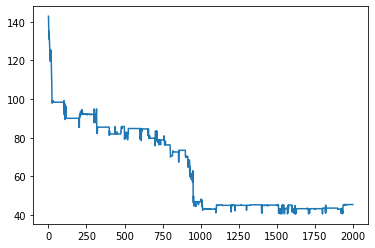

Score: 6: 100%|█████████████████████████████████████████████████████████████████| 20/20 [15:00<00:00, 45.04s/ episodes]

Case:2   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:19    best step:78
DELAY	initial:147.08, new:40.55
1


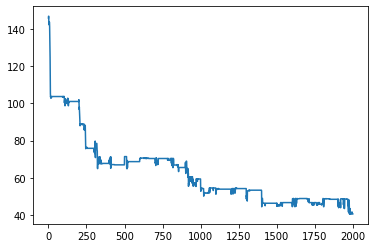

Score: 0: 100%|█████████████████████████████████████████████████████████████████| 20/20 [14:46<00:00, 44.35s/ episodes]

Case:3   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:14    best step:23
DELAY	initial:147.08, new:40.55
2


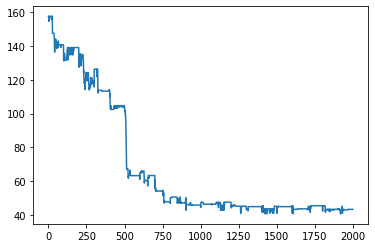

Score: 0: 100%|█████████████████████████████████████████████████████████████████| 20/20 [14:44<00:00, 44.24s/ episodes]

Case:4   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:12    best step:19
DELAY	initial:147.08, new:40.55
3


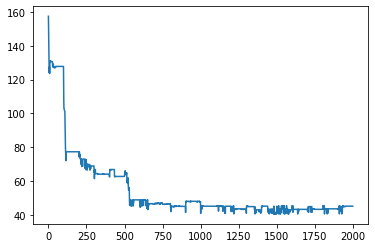

Score: 0: 100%|█████████████████████████████████████████████████████████████████| 20/20 [14:46<00:00, 44.32s/ episodes]

Case:5   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:9    best step:65
DELAY	initial:147.08, new:40.55
4


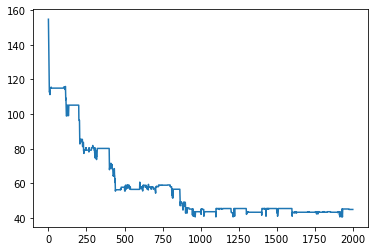

Score: 0: 100%|█████████████████████████████████████████████████████████████████| 20/20 [14:43<00:00, 44.19s/ episodes]

Case:6   traffic:1
---------------------------------------------------------------
movement	 EBL;  WBT;  SBL;  NBT;  WBL;  EBT;  NBL;  SBT
---------------------------------------------------------------
traffic		 100;  600;  100;  600;  100;  600;  100;  600
traffic percent	0.07; 0.43; 0.07; 0.43; 0.07; 0.43; 0.07; 0.43 
initial signal	  30;   30;   30;   30;   30;   30;   30;   30
best signal	  13;   47;   13;   47;   13;   47;   13;   47
signal percent	0.11; 0.39; 0.11; 0.39; 0.11; 0.39; 0.11; 0.39 
---------------------------------------------------------------
best epi:3    best step:70
DELAY	initial:147.08, new:40.55
5


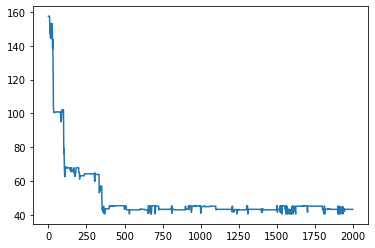

In [21]:
n, j = 0, 0
signal = [30,30,30,30,30,30,30,30]
tf_lane = np.array([[1,2],[1,2],[1,2],[1,2]])

DELAY_Test_DF = []
REWARD_Test_DF = []
cul_reward_DF = []

for t in range(len(traffic)):
    for i in range(REPEAT_TRAIN):
        best_sig, best_delay, best_epi, best_step, results, ini_delay = DDPG_Agent.train(Episode, Max_Step, signal, traffic[t],
                                                                        FFS[n][j], Sat[n][j], W[n][j], Lane[n][j], Link_len[n][j],
                                                                        LT_bay[n][j], LT_bay_len[n][j], Sig_type[n][j], FIFO[n][j],
                                                                        cycle[n][j], yellow[n][j], offset[n][j], Min_phase[n][j])

        t_p_l = traffic[t]/tf_lane
        t_r1 = t_p_l[0][0]+t_p_l[1][1]+t_p_l[2][0]+t_p_l[3][1]
        t_r2 = t_p_l[1][0]+t_p_l[0][1]+t_p_l[3][0]+t_p_l[2][1]
        sig_r1 = best_sig[0]+best_sig[1]+best_sig[2]+best_sig[3]
        sig_r2 = best_sig[4]+best_sig[5]+best_sig[6]+best_sig[7]
        print("===============================================================")
        print("Case:{0}   traffic:{1}".format(i+1, t+1))
        print("---------------------------------------------------------------")
        print("movement\t {};  {};  {};  {};  {};  {};  {};  {}".format("EBL", "WBT", "SBL", "NBT", "WBL", "EBT", "NBL", "SBT"))
        print("---------------------------------------------------------------")
        print("traffic\t\t{0:4.0f}; {1:4.0f}; {2:4.0f}; {3:4.0f}; {4:4.0f}; {5:4.0f}; {6:4.0f}; {7:4.0f}".format(t_p_l[0][0],t_p_l[1][1],t_p_l[2][0],t_p_l[3][1],t_p_l[1][0],t_p_l[0][1],t_p_l[3][0],t_p_l[2][1]))
        print("\033[31m" "traffic percent\t{0:.2f}; {1:.2f}; {2:.2f}; {3:.2f}; {4:.2f}; {5:.2f}; {6:.2f}; {7:.2f}".format(t_p_l[0][0]/t_r1,t_p_l[1][1]/t_r1,t_p_l[2][0]/t_r1,t_p_l[3][1]/t_r1,t_p_l[1][0]/t_r2,t_p_l[0][1]/t_r2,t_p_l[3][0]/t_r2,t_p_l[2][1]/t_r2),"\033[0m")
        print("initial signal\t{0:4d}; {1:4d}; {2:4d}; {3:4d}; {4:4d}; {5:4d}; {6:4d}; {7:4d}".format(signal[0],signal[1],signal[2],signal[3],signal[4],signal[5],signal[6],signal[7]))
        print("best signal\t{0:4d}; {1:4d}; {2:4d}; {3:4d}; {4:4d}; {5:4d}; {6:4d}; {7:4d}".format(int(best_sig[0]),int(best_sig[1]),int(best_sig[2]),int(best_sig[3]),int(best_sig[4]),int(best_sig[5]),int(best_sig[6]),int(best_sig[7])))
        print("\033[31m" "signal percent\t{0:.2f}; {1:.2f}; {2:.2f}; {3:.2f}; {4:.2f}; {5:.2f}; {6:.2f}; {7:.2f}".format(best_sig[0]/sig_r1,best_sig[1]/sig_r1,best_sig[2]/sig_r1,best_sig[3]/sig_r1,best_sig[4]/sig_r2,best_sig[5]/sig_r2,best_sig[6]/sig_r2,best_sig[7]/sig_r2),"\033[0m")
        print("---------------------------------------------------------------")
        print("best epi:{0}    best step:{1}".format(best_epi, best_step))
        print("DELAY\tinitial:{0:.2f}, new:{1:.2f}".format(ini_delay, best_delay))
        print("===============================================================") 
        
        cul_reward = []

        for num in range(len(REWARD_Test)):
            if num == 0:
                cul_reward.append(REWARD_Test[0])
            else:
                cul_reward.append(cul_reward[num-1]+REWARD_Test[num])
        print(i)
        plt.plot(DELAY_Test)
        plt.show()        
        
        if i == 0:
            ### 파일로 저장 ###_DELAY_Test, REWARD_Test, cul_reward
            DELAY_Test_DF.append(pd.DataFrame(DELAY_Test))
            DELAY_Test_DF[t].columns = ["REPEAT 1"]

            REWARD_Test_DF.append(pd.DataFrame(REWARD_Test))
            REWARD_Test_DF[t].columns = ["REPEAT 1"]        

            cul_reward_DF.append(pd.DataFrame(cul_reward))
            cul_reward_DF[t].columns = ["REPEAT 1"]          

        else:
            DELAY_Test_DF[t].insert(i, "REPEAT "+str(i+1), DELAY_Test)
            REWARD_Test_DF[t].insert(i, "REPEAT "+str(i+1), REWARD_Test)
            cul_reward_DF[t].insert(i, "REPEAT "+str(i+1), cul_reward)


        print("\n")
        DELAY_Test = []
        REWARD_Test = []        

In [22]:
for t in range(len(traffic)):
    DELAY_Test_DF[t].to_csv('DF/21-1227/Traffic_{}_Scn_B_delay_22-0802.csv'.format(t),encoding = 'euc-kr')
    cul_reward_DF[t].to_csv('DF/21-1227/Traffic_{}_Scn_B_cul_reward.csv_22-0802'.format(t),encoding = 'euc-kr')